# **Question 1**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class NeuralNetwork:
    class Layer:
        def __init__(self, input_size, output_size, activation, wtb_init = 'random'):
            self.vals = None
            self.res = None
            self.activation = activation
            self.weights, self.bias = self.__init_wtb__(input_size, output_size, wtb_init)

        def __init_wtb__(self, input_size, output_size, init_mth):
            if init_mth == 'random':
                weights = np.random.rand(input_size, output_size)
                bias = np.random.rand(output_size)
            elif init_mth == 'zeros':
                weights = np.zeros((input_size, output_size))
                bias = np.zeros(output_size)
            elif init_mth == 'normal':
                mean, std_dev = 0, 0.1
                weights = np.random.normal(mean, std_dev, (input_size, output_size))
                bias = np.random.normal(mean, std_dev, output_size)
            else:
                raise ValueError("Invalid initialization method. Use 'random', 'zeros', or 'normal'.")
            return weights, bias

        def __get_act__(self, x):
            if self.activation == 'sigmoid':
                return 1 / (1 + np.exp(-x))
            elif self.activation == 'relu':
                return np.maximum(0, x)
            elif self.activation == 'tanh':
                return np.tanh(x)
            elif self.activation == 'linear':
                return x

        def __get_act_grad__(self, x):
            if self.activation == 'sigmoid':
                z = 1 / (1 + np.exp(-x))
                return z * (1 - z)
            elif self.activation == 'relu':
                return np.where(x > 0, 1, 0)
            elif self.activation == 'tanh':
                return 1-np.tanh(x)**2
            elif self.activation == 'linear':
                return np.ones_like(x)

        def forward(self, vals):
            self.vals = vals
            self.res = np.dot(self.vals, self.weights) + self.bias
            return self.__get_act__(self.res)

        def backward(self, err, lr):
            grad_x = self.__get_act_grad__(self.res) * err
            nex_err = np.dot(grad_x, self.weights.T)
            self.weights = self.weights - lr * np.dot(self.vals.T, err)
            self.bias = self.bias - lr * err
            return nex_err

    def __init__(self):
        self.layers = []

    def __loss_func(self,y_true, y_pred, loss ='mse'):
        n = len(y_true)
        diff = y_true - y_pred

        if loss == 'mse':
            err = np.mean(diff**2)
        elif loss == 'cross_entropy':
            eps = 1e-15
            clpd_preds = np.clip(y_pred, eps, 1 - eps)
            err = -np.sum(y_true * np.log(clpd_preds)) / n
        else:
            raise ValueError("Invalid loss type. Use 'mse' or 'cross_entropy'.")

        return err

    def __grad_loss(self, y_true, y_pred, loss='mse'):
        n = len(y_true)
        diff = y_true - y_pred

        if loss == 'mse':
            grad_err = -2 * diff / n
        elif loss == 'cross_entropy':
            eps = 1e-15
            clpd_preds = np.clip(y_pred, eps, 1 - eps)
            grad_err = -y_true / (clpd_preds * n)
        else:
            raise ValueError("Invalid loss type. Use 'mse' or 'cross_entropy'.")

        return grad_err


    def add(self, input_size, output_size, activation):
        self.layers.append(self.Layer(input_size = input_size, output_size = output_size, activation = activation))

    def __f_prop__(self, input):
        res = input
        for layer in self.layers:
            res = layer.forward(res)
        return res
    def __b_prop__(self, err, lr):
        res = err
        rev_lyr = reversed(self.layers)
        for layer in rev_lyr:
            res = layer.backward(res, lr)
        return res

    def print_weights(self, epoch):
        print(f"\n{'=' * 30} Epoch {epoch + 1} {'=' * 30}")
        for i, layer in enumerate(self.layers):
            print(f"Layer {i + 1} Weights:")
            for k in range(layer.weights.shape[0]):
                print(f"  Neuron_{k + 1:<3}", end="")
                for w in layer.weights[k]:
                    print(f"  {w:.4f}  ", end="")
                print()

        print("-" * 50)

    def predict(self, X):
        predictions = []
        for sample in range(X.shape[0]):
            pred = self.__f_prop__(X[sample])
            predictions.append(pred)
        return np.array(predictions)

    def score(self, X, y):
        predictions = self.predict(X)
        accuracy = np.sum(np.round(predictions) == y) / len(y)
        return accuracy

    def fit(self, X_train, y_train, X_val, y_val, epochs, learning_rate, plot=False, verbose=False, accuracy=True):
        samples = X_train.shape[0]
        train_errors = []
        val_errors = []
        val_accuracies = []
        train_accuracies = []

        for epoch in range(epochs):
            err = 0
            val_err = 0

            for sample in range(samples):
                curr = X_train[sample]
                pred = self.__f_prop__(curr)
                err += self.__loss_func(y_train[sample], pred)

                in_err = self.__grad_loss(y_train[sample], pred)
                self.__b_prop__(in_err, learning_rate)

            for val_sample in range(X_val.shape[0]):
                val_pred = self.__f_prop__(X_val[val_sample])
                val_err += self.__loss_func(y_val[val_sample], val_pred)

            err /= samples
            val_err /= X_val.shape[0]

            train_errors.append(err)
            val_errors.append(val_err)

            if accuracy:
                val_accuracy = self.score(X_val, y_val)
                train_accuracy = self.score(X_train, y_train)
                val_accuracies.append(val_accuracy)
                train_accuracies.append(train_accuracy)

            if verbose:
                self.print_weights(epoch)
                print(f'Training Error: {err:.4f}   Validation Error: {val_err:.4f}\n')

        if plot:
            plt.plot(range(1, epochs + 1), train_errors, label='Training Loss', color='blue')
            plt.plot(range(1, epochs + 1), val_errors, label='Validation Loss', color='green')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

        if accuracy:
            plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='red')
            plt.plot(range(1, epochs + 1), train_accuracies, label='Test Accuracy', color='purple')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()
        print(f'Training Accuracy: {self.score(X_train, y_train):.4f}   Validation Accuracy: {self.score(X_val, y_val):.4f}\n')

In [3]:
from sklearn.model_selection import train_test_split


============================== Epoch 1 ==============================
Layer 1 Weights:
  Neuron_1    0.4011    0.8976    0.8238    0.1899  
  Neuron_2    0.5065    0.6048    0.8309    0.2832  
Layer 2 Weights:
  Neuron_1    -0.0573  
  Neuron_2    0.8848  
  Neuron_3    0.1781  
  Neuron_4    0.3625  
--------------------------------------------------
Training Error: 0.1258   Validation Error: 0.0990


============================== Epoch 2 ==============================
Layer 1 Weights:
  Neuron_1    0.3922    0.9746    0.8334    0.2169  
  Neuron_2    0.5157    0.5233    0.8206    0.2554  
Layer 2 Weights:
  Neuron_1    -0.1526  
  Neuron_2    0.9616  
  Neuron_3    0.0667  
  Neuron_4    0.2852  
--------------------------------------------------
Training Error: 0.0898   Validation Error: 0.0592


============================== Epoch 3 ==============================
Layer 1 Weights:
  Neuron_1    0.3810    1.0338    0.8345    0.2322  
  Neuron_2    0.5268    0.4620    0.8187    0.2

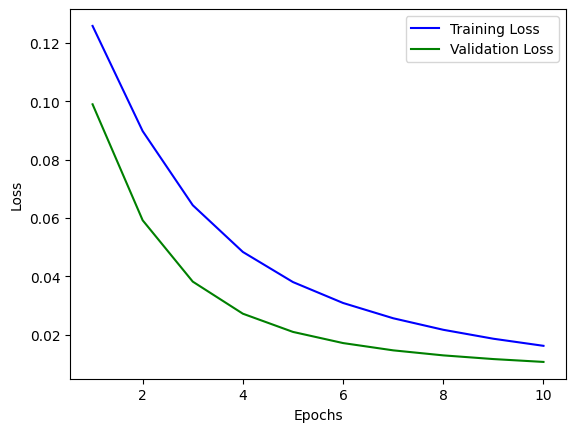

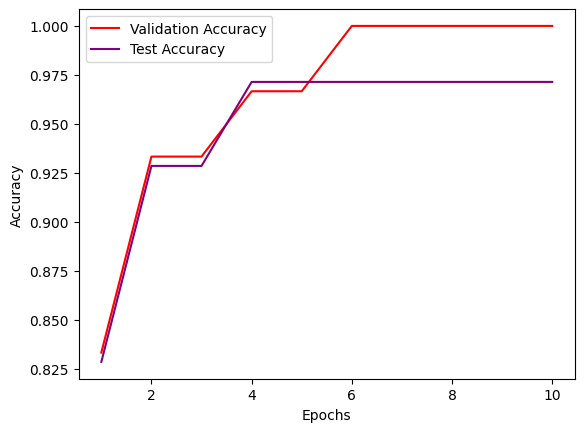

Training Accuracy: 0.9714   Validation Accuracy: 1.0000



In [4]:
np.random.seed(42)

X = np.random.randint(-5, 5, size=(100, 1, 2))
y = np.array([[[0]] if x[0, 0] < 0 else [[1]] for x in X])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

model = NeuralNetwork()
model.add(input_size=2, output_size=4, activation="linear")
model.add(input_size=4, output_size=1, activation="sigmoid")
model.fit(X_train, y_train, X_val, y_val, epochs = 10, learning_rate= 0.01, plot= True, verbose=True, accuracy=True)


# Report
## Dataset
The dataset consists of 100 points, each with 2 coordinates generated randomly between -5 and 5. The labels are binary, assigned based on whether the x-coordinate is less than 0.

## Analysis
The model demonstrates a consistent decrease in both training and validation losses, suggesting effective learning during backpropagation. Training and validation accuracies steadily increase, reaching 97.14% and 100%, respectively.

## Explanation
The observed trends reveal the model's ability to fine-tune weights, capturing intricate patterns. As epochs progress, the diminishing rate of loss reduction suggests approaching convergence, while rising accuracies affirm the model's capacity to generalize well to both training and validation datasets, yielding high accuracy.

# **Question 2**

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
X = pd.read_csv("gene_exp_X")
X.set_index('Gene Accession Number', inplace=True)
X

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
Gene Accession Number,,,,,,,,,,,,,,,,,,,,,
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,-154,-136,49,180,-257,-273,141,-123,52,878,...,214,540,13,1075,-45,524,249,40,-68,-1
69,-79,-118,-30,68,-110,-264,-28,-61,40,-217,...,409,617,-34,738,11,742,234,72,109,-30
70,-55,-44,12,129,-108,-301,-222,-133,136,320,...,131,318,35,241,-66,320,174,-4,176,40


In [18]:
y = pd.read_csv("gene_exp_y")
y.set_index('patient', inplace=True)
y

,cancer
patient,
1,0
2,0
3,0
4,0
5,0
...,...
68,0
69,0
70,0


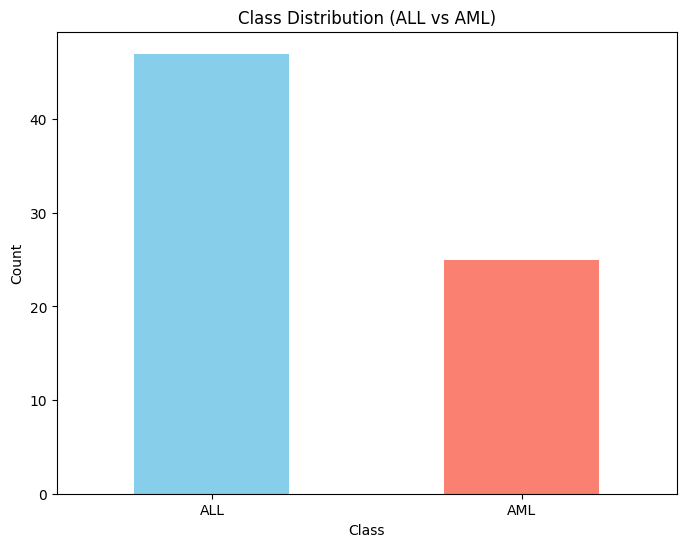

Class Distribution:
0    47
1    25
Name: cancer, dtype: int64

Class Proportions:
Class 0: 65.28%
Class 1: 34.72%


In [19]:
def class_distro(df):

    plt.figure(figsize=(8, 6))
    df['cancer'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Class Distribution (ALL vs AML)')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['ALL', 'AML'], rotation=0)
    plt.show()

    cls_dist= df['cancer'].value_counts()
    print("Class Distribution:")
    print(cls_dist)
    print()
    class_proportions = df.value_counts(normalize=True)
    print("Class Proportions:")
    print(f"Class 0: {class_proportions[0]:.2%}")
    print(f"Class 1: {class_proportions[1]:.2%}")

class_distro(y)

The class distribution provides insights into the proportion of ALL (Class 0) and AML (Class 1) samples, allowing us to identify the imbalanced nature of the dataset.

## Evaluation Metric

The F1 score is favored for imbalanced datasets due to its balanced consideration of precision and recall. It provides a robust evaluation, particularly when the minority class is of greater interest, offering a stable metric less influenced by class imbalance, and facilitating threshold adjustments for improved model performance.

Hence F1 score is used to evaluate the models.

# Resample
we can down sample ALL to get a more balanced data

## Downsample

In [20]:
from sklearn.utils import resample

In [21]:
def downsample(X, y):
    # Separate the majority and minority classes in y
    mc_y = y[y['cancer'] == 0]
    mnc_y = y[y['cancer'] == 1]

    dwnsmpld_mc_y = resample(mc_y, replace=False, n_samples=len(mnc_y), random_state=42)

    y_d = pd.concat([dwnsmpld_mc_y, mnc_y])
    X_d = X.loc[y_d.index]

    return X_d, y_d
X_d, y_d = downsample(X, y)

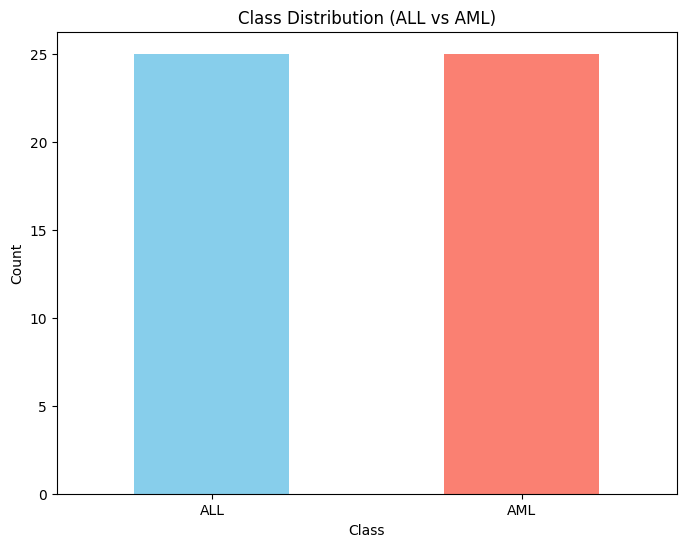

Class Distribution:
0    25
1    25
Name: cancer, dtype: int64

Class Proportions:
Class 0: 50.00%
Class 1: 50.00%


In [22]:
class_distro(y_d)

## Upsample

In [24]:
from imblearn.over_sampling import SMOTE

In [25]:
# Step 1: Initialize SMOTE
smote = SMOTE(sampling_strategy='auto' ,random_state=42)

# Step 2: Resample the data
X_u, y_u = smote.fit_resample(X, y)


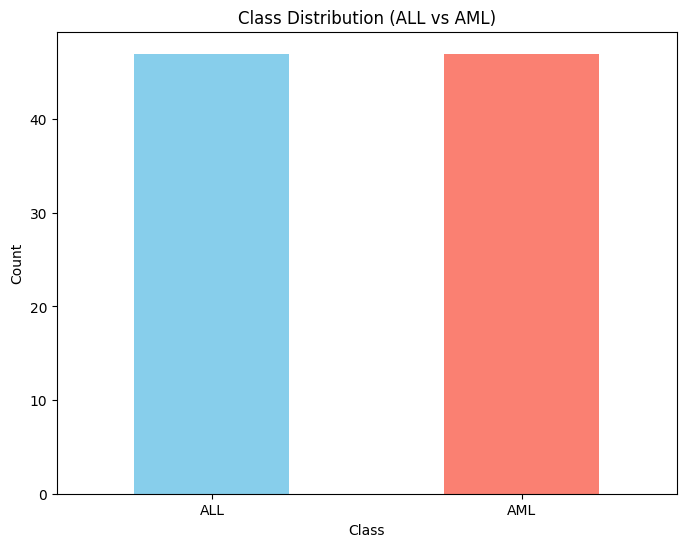

Class Distribution:
0    47
1    47
Name: cancer, dtype: int64

Class Proportions:
Class 0: 50.00%
Class 1: 50.00%


In [26]:
class_distro(y_u)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [28]:


# Define custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.math.round(y_pred), tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

# Function to train and plot the neural network
def train_and_plot_nn(X, y, test_size=0.2, random_state=42, epochs=100, batch_size=64):
    # Standardize the input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data into training and validation sets
    # class_weights = dict(1 / y_train.astype(int).value_counts(normalize=True))
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)

    # Calculate class weights based on class distribution
    class_weights = {0: 1.5405405405405406, 1: 2.85}

    # Build the neural network model
    NN_model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=X_train.shape[1:]),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model with the custom F1 score metric
    NN_model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=[F1Score()]
    )

    # Train the model
    history = NN_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val), class_weight=class_weights,
        batch_size=batch_size,
        epochs=epochs
    )

    # Plot the training history
    fig, ax = plt.subplots(1, 2, dpi=200, figsize=(4.2, 2.1))
    ax[0].plot(history.history['loss'], label="train loss", lw=0.5)
    ax[0].plot(history.history['val_loss'], label="val loss", lw=0.5)
    ax[1].plot(history.history['f1_score'], label="train F1 score", lw=0.5)
    ax[1].plot(history.history['val_f1_score'], label="val F1 score", lw=0.5)
    ax[0].legend(fontsize=5)
    ax[1].legend(fontsize=5)
    ax[0].set_title("Loss curve", fontsize=7)
    ax[1].set_title("F1 Score curve", fontsize=7)
    ax[0].set_xlabel("epoch", fontsize=5)
    ax[1].set_xlabel("epoch", fontsize=5)
    ax[0].set_ylabel("loss", fontsize=5)
    ax[1].set_ylabel("F1 Score", fontsize=5)
    ax[0].tick_params(axis='both', which='major', labelsize=5)
    ax[1].tick_params(axis='both', which='major', labelsize=5)
    plt.suptitle("Neural Network Training with F1 Score", fontsize=8)
    plt.tight_layout()
    plt.show()


### Original Dataset

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 2.1069 - f1_score: 0.4706 - val_loss: 0.2667 - val_f1_score: 0.9091
Epoch 2/100
1/1 [==============================] - 0s 94ms/step - loss: 1.2383 - f1_score: 0.6415 - val_loss: 0.1973 - val_f1_score: 0.9091
Epoch 3/100
1/1 [==============================] - 0s 128ms/step - loss: 0.7729 - f1_score: 0.7200 - val_loss: 0.1542 - val_f1_score: 0.9091
Epoch 4/100
1/1 [==============================] - 0s 83ms/step - loss: 0.6942 - f1_score: 0.8372 - val_loss: 0.1241 - val_f1_score: 0.9091
Epoch 5/100
1/1 [==============================] - 0s 121ms/step - loss: 0.9748 - f1_score: 0.7317 - val_loss: 0.1196 - val_f1_score: 0.9091
Epoch 6/100
1/1 [==============================] - 0s 92ms/step - loss: 1.1081 - f1_score: 0.7755 - val_loss: 0.1243 - val_f1_score: 0.9091
Epoch 7/100
1/1 [==============================] - 0s 122ms/step - loss: 0.5649 - f1_score: 0.8163 - val_loss: 0.1348 - val_f1_score: 0.9091
Epoch 8/100
1/1 [==

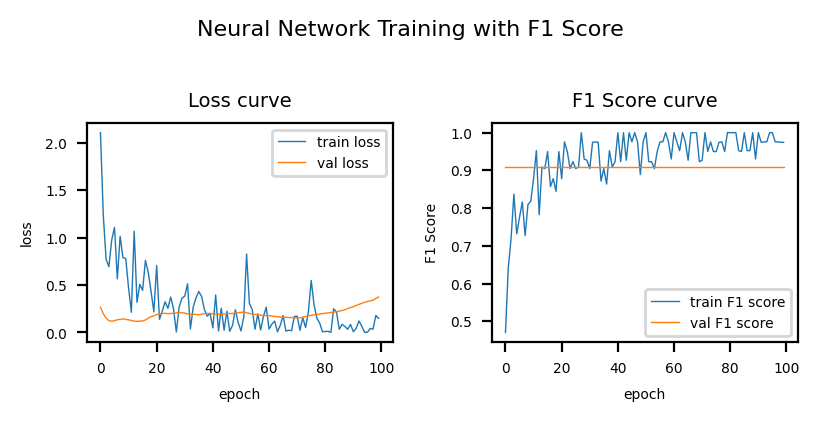

In [30]:
train_and_plot_nn(X, y)

### Upsampled Dataset

Epoch 1/100
2/2 [==============================] - 3s 680ms/step - loss: 3.0772 - f1_score: 0.4478 - val_loss: 0.1581 - val_f1_score: 0.8571
Epoch 2/100
2/2 [==============================] - 0s 158ms/step - loss: 1.4139 - f1_score: 0.7949 - val_loss: 0.0704 - val_f1_score: 1.0000
Epoch 3/100
2/2 [==============================] - 0s 109ms/step - loss: 2.0004 - f1_score: 0.8000 - val_loss: 0.0485 - val_f1_score: 1.0000
Epoch 4/100
2/2 [==============================] - 0s 91ms/step - loss: 1.2941 - f1_score: 0.8395 - val_loss: 0.0437 - val_f1_score: 1.0000
Epoch 5/100
2/2 [==============================] - 0s 106ms/step - loss: 1.1954 - f1_score: 0.8571 - val_loss: 0.0334 - val_f1_score: 1.0000
Epoch 6/100
2/2 [==============================] - 0s 111ms/step - loss: 1.1770 - f1_score: 0.8312 - val_loss: 0.0279 - val_f1_score: 1.0000
Epoch 7/100
2/2 [==============================] - 0s 101ms/step - loss: 1.1182 - f1_score: 0.8500 - val_loss: 0.0225 - val_f1_score: 1.0000
Epoch 8/100
2/

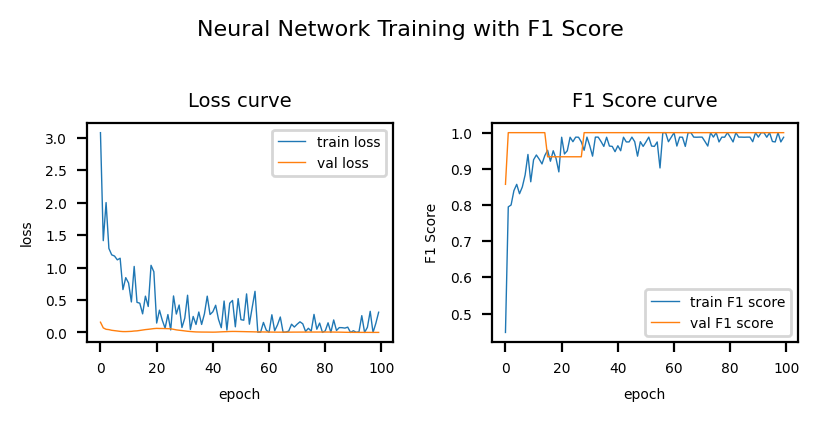

In [31]:
train_and_plot_nn(X_u, y_u)

### Downsampled Dataset

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 2.1465 - f1_score: 0.5581 - val_loss: 0.5910 - val_f1_score: 0.8000
Epoch 2/100
1/1 [==============================] - 0s 72ms/step - loss: 3.1036 - f1_score: 0.5789 - val_loss: 0.2976 - val_f1_score: 0.8571
Epoch 3/100
1/1 [==============================] - 0s 61ms/step - loss: 1.5248 - f1_score: 0.7692 - val_loss: 0.1886 - val_f1_score: 0.9333
Epoch 4/100
1/1 [==============================] - 0s 60ms/step - loss: 0.7379 - f1_score: 0.9444 - val_loss: 0.2008 - val_f1_score: 0.8750
Epoch 5/100
1/1 [==============================] - 0s 46ms/step - loss: 2.0183 - f1_score: 0.7568 - val_loss: 0.2273 - val_f1_score: 0.8750
Epoch 6/100
1/1 [==============================] - 0s 61ms/step - loss: 1.5012 - f1_score: 0.6857 - val_loss: 0.2442 - val_f1_score: 0.8750
Epoch 7/100
1/1 [==============================] - 0s 46ms/step - loss: 1.1242 - f1_score: 0.8000 - val_loss: 0.2760 - val_f1_score: 0.8750
Epoch 8/100
1/1 [=====

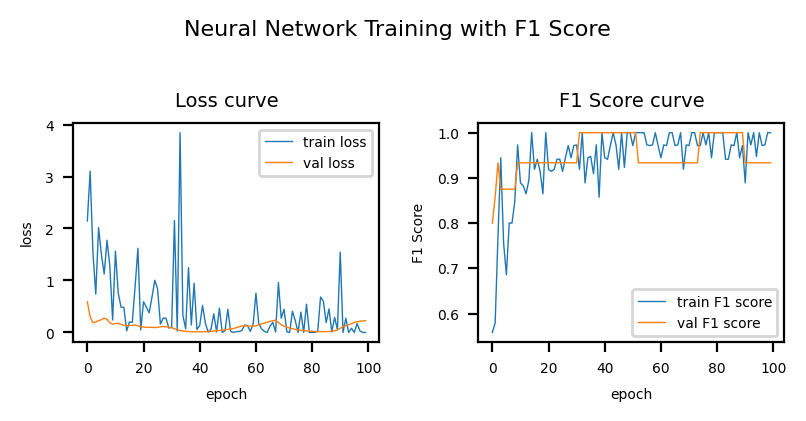

In [32]:
train_and_plot_nn(X_d, y_d)

# **Justification for Downsampling and Upsampling Strategies in Imbalanced Data Handling**

Imbalanced Data Challenges:

F1 Score as Evaluation Metric:
The F1 score is chosen as the evaluation metric due to its balanced consideration of precision and recall.
It is robust for imbalanced datasets, particularly when the minority class is of greater interest.
F1 score offers stability, being less influenced by class imbalance, and allows threshold adjustments for improved model performance.
Resampling Strategies:
Resampling is a common approach to address class imbalance.
Two strategies are employed: downsampling the majority class (ALL) and upsampling using SMOTE.

Downsampling (Downsampled Dataset):

* Objective:
Train on a more balanced dataset by downsampling the majority class (ALL).
* Implementation:
Randomly select a subset of ALL samples to match the number of AML samples.
* Effect:
Improves balance, making the training set moderately imbalanced with a better proportion of positives to negatives.


Upsampling (Upsampled Dataset):

* Objective:
Address class imbalance by generating synthetic samples for the minority class (AML) using SMOTE.
* Implementation:
Initialize SMOTE and resample the data to achieve a more balanced distribution.
* Effect:
Increases the number of minority class samples, contributing to a more balanced dataset.

# Neural Network Training and Evaluation:
* Neural Network Architecture:
A neural network model is built with a custom F1 score metric.
Training is performed on the original, upsampled, and downsampled datasets.
* Class Weights:
Class weights are calculated based on the distribution of the target variable.
* Training and Evaluation:
The F1 score is monitored during training to assess the model's performance.

# Justification for Effectiveness:

1. F1 Score as Evaluation Metric:
  * F1 score provides a balanced assessment, crucial for imbalanced datasets.
  * Stability in performance evaluation, especially when the minority class is of higher interest.
2. Downsampling:
  * Advantages:
    * Improves balance, addressing the challenge of insufficient learning from the minority class.
    * Faster convergence by focusing more on the minority class during training.
    * Efficient disk space utilization by consolidating the majority class into fewer examples.
3. Upsampling:
  * Advantages:
    * Generates synthetic samples, enhancing the representation of the minority class.
    * Addresses issues of insufficient positive examples, improving model learning.
4. Neural Network Training:
  * Models trained on both upsampled and downsampled datasets demonstrate the adaptability of the neural network to different strategies.
  * Evaluation using F1 score allows a comprehensive understanding of model performance, considering both precision and recall.

  
In conclusion, both downsampling and upsampling strategies are effective for handling imbalanced data, addressing challenges related to biased learning, convergence speed, and resource utilization. The choice between the two depends on the specific characteristics of the dataset and the desired trade-offs in model performance.


# **Question 3**

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [34]:
X = pd.read_csv("gene_exp_X")
X.set_index('Gene Accession Number', inplace=True)
X

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
Gene Accession Number,,,,,,,,,,,,,,,,,,,,,
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,-154,-136,49,180,-257,-273,141,-123,52,878,...,214,540,13,1075,-45,524,249,40,-68,-1
69,-79,-118,-30,68,-110,-264,-28,-61,40,-217,...,409,617,-34,738,11,742,234,72,109,-30
70,-55,-44,12,129,-108,-301,-222,-133,136,320,...,131,318,35,241,-66,320,174,-4,176,40


In [35]:
y = pd.read_csv("gene_exp_y")
y.set_index('patient', inplace=True)
y

,cancer
patient,
1,0
2,0
3,0
4,0
5,0
...,...
68,0
69,0
70,0


Therefore there are 72 sample to train the model, for the given dataset.

## Method 1 : K-Fold cross validation

K-Fold validation divides a dataset into k subsets, training the model k times. Each time, one of the k subsets is used as the validation set, and the remaining k-1 subsets form the training set. This helps assess model performance by providing multiple evaluations, reducing the impact of data partitioning.

In [36]:
from sklearn.model_selection import StratifiedKFold

Training Fold 1/10... for 100 epochs
Training Fold 2/10... for 100 epochs
Training Fold 3/10... for 100 epochs
Training Fold 4/10... for 100 epochs
Training Fold 5/10... for 100 epochs
Training Fold 6/10... for 100 epochs
Training Fold 7/10... for 100 epochs
Training Fold 8/10... for 100 epochs
Training Fold 9/10... for 100 epochs
Training Fold 10/10... for 100 epochs


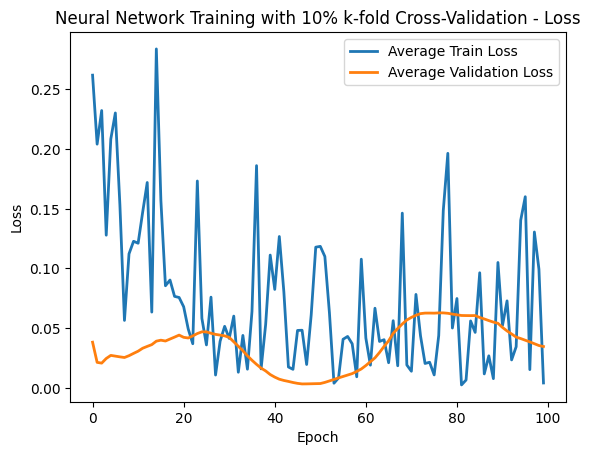

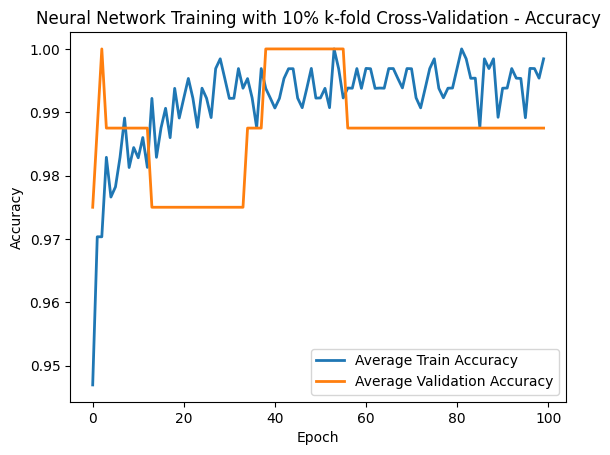

In [37]:
def nn_kfold(X, y, n_splits=10, random_state=42, epochs=100, batch_size=64):
    # Standardize the input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    y_array = y.to_numpy()

    class_weights = {0: 1.5405405405405406, 1: 2.85}

    # Build the neural network model
    NN_model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=X_scaled.shape[1:]),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    NN_model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    all_train_loss = []
    all_val_loss = []
    all_train_accuracy = []
    all_val_accuracy = []

    # Train and evaluate the model using k-fold cross-validation
    for fold_num, (train_index, val_index) in enumerate(skf.split(X_scaled, y_array), 1):
        print(f"Training Fold {fold_num}/{n_splits}... for {epochs} epochs")

        # Split the data into training and validation sets
        X_train, X_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_val = y_array[train_index], y_array[val_index]

        history = NN_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val), class_weight=class_weights,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0
        )

        all_train_loss.append(history.history['loss'])
        all_val_loss.append(history.history['val_loss'])
        all_train_accuracy.append(history.history['accuracy'])
        all_val_accuracy.append(history.history['val_accuracy'])

    plot_average_history(all_train_loss, all_val_loss, "Loss")
    plot_average_history(all_train_accuracy, all_val_accuracy, "Accuracy")

def plot_average_history(all_train_values, all_val_values, metric_name):
    avg_train_values = np.mean(all_train_values, axis=0)
    avg_val_values = np.mean(all_val_values, axis=0)

    plt.plot(avg_train_values, label="Average Train " + metric_name, lw=2)
    plt.plot(avg_val_values, label="Average Validation " + metric_name, lw=2)

    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"Neural Network Training with 10% k-fold Cross-Validation - {metric_name}")
    plt.legend()
    plt.show()

nn_kfold(X, y)


## Method 2 :Leave-One-Out Cross-Validation

LOOCV, suitable for limited datasets, involves training on all but one sample and validating on the excluded sample iteratively. While computationally intensive, LOOCV maximizes data utilization, critical for small datasets where random splits in standard train-test splits might lead to high model variance due to limited sample diversity.

Training Fold 1/72 for 100 epochs...
Training Fold 2/72 for 100 epochs...
Training Fold 3/72 for 100 epochs...
Training Fold 4/72 for 100 epochs...
Training Fold 5/72 for 100 epochs...
Training Fold 6/72 for 100 epochs...
Training Fold 7/72 for 100 epochs...
Training Fold 8/72 for 100 epochs...
Training Fold 9/72 for 100 epochs...
Training Fold 10/72 for 100 epochs...
Training Fold 11/72 for 100 epochs...
Training Fold 12/72 for 100 epochs...
Training Fold 13/72 for 100 epochs...
Training Fold 14/72 for 100 epochs...
Training Fold 15/72 for 100 epochs...
Training Fold 16/72 for 100 epochs...
Training Fold 17/72 for 100 epochs...
Training Fold 18/72 for 100 epochs...
Training Fold 19/72 for 100 epochs...
Training Fold 20/72 for 100 epochs...
Training Fold 21/72 for 100 epochs...
Training Fold 22/72 for 100 epochs...
Training Fold 23/72 for 100 epochs...
Training Fold 24/72 for 100 epochs...
Training Fold 25/72 for 100 epochs...
Training Fold 26/72 for 100 epochs...
Training Fold 27/72 f

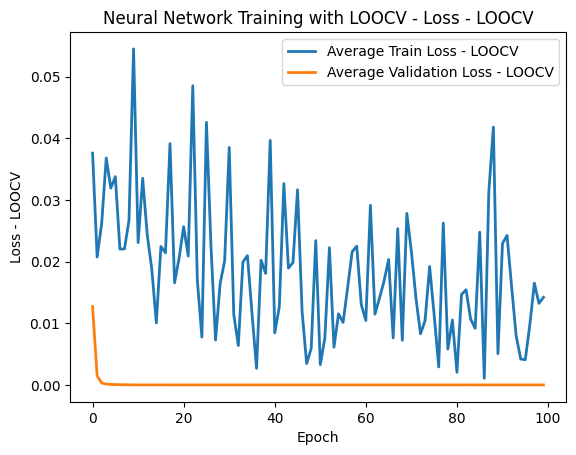

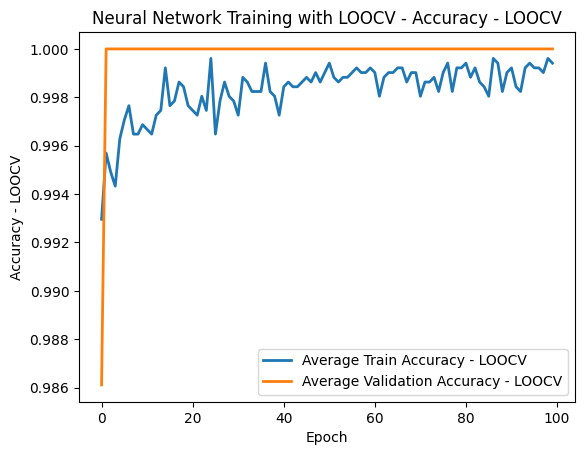

In [38]:
from sklearn.model_selection import LeaveOneOut

def nn_loocv(X, y, epochs=100, batch_size=64):
    # Standardize the input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert y to a NumPy array for indexing
    y_array = y.to_numpy()

    # Calculate class weights based on class distribution
    class_weights = {0: 1.5405405405405406, 1: 2.85}

    # Build the neural network model
    NN_model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=X_scaled.shape[1:]),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model with accuracy as the metric
    NN_model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    # Initialize LeaveOneOut
    loo = LeaveOneOut()

    # Initialize lists to store loss and accuracy for each fold
    all_train_loss = []
    all_val_loss = []
    all_train_accuracy = []
    all_val_accuracy = []

    # Train and evaluate the model using LOOCV
    for fold_num, (train_index, val_index) in enumerate(loo.split(X_scaled), 1):
        print(f"Training Fold {fold_num}/{X_scaled.shape[0]} for {epochs} epochs...")

        # Split the data into training and validation sets
        X_train, X_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_val = y_array[train_index], y_array[val_index]

        # Train the model
        history = NN_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val), class_weight=class_weights,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0  # Set verbose to 0 to suppress output during training
        )

        # Append loss and accuracy values to lists
        all_train_loss.append(history.history['loss'])
        all_val_loss.append(history.history['val_loss'])
        all_train_accuracy.append(history.history['accuracy'])
        all_val_accuracy.append(history.history['val_accuracy'])

    # Plot the average training history over all folds
    plot_avg_hist(all_train_loss, all_val_loss, "Loss - LOOCV")
    plot_avg_hist(all_train_accuracy, all_val_accuracy, "Accuracy - LOOCV")

def plot_avg_hist(all_train_values, all_val_values, metric_name):
    # Calculate average values over all folds
    avg_train_values = np.mean(all_train_values, axis=0)
    avg_val_values = np.mean(all_val_values, axis=0)

    # Plot the average training history
    plt.plot(avg_train_values, label="Average Train " + metric_name, lw=2)
    plt.plot(avg_val_values, label="Average Validation " + metric_name, lw=2)

    # Plot settings
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"Neural Network Training with LOOCV - {metric_name}")
    plt.legend()
    plt.show()

# Example usage
nn_loocv(X, y)


## Rationale

K-Fold CV provides a balance between robust evaluation and computational efficiency. By partitioning the dataset into multiple folds, it captures variations in the data distribution and helps detect potential overfitting. The average performance over multiple folds offers a reliable estimate of the model's generalization. However, it may be computationally expensive, especially with large datasets, and the choice of the number of folds (k) can influence results.

On the other hand, LOOCV maximizes data utilization by systematically leaving out a single sample for validation, providing an exhaustive assessment with minimal bias. This approach is particularly beneficial for small datasets, ensuring each data point contributes to model evaluation. However, LOOCV is computationally demanding, especially with larger datasets, and may be sensitive to outliers.